In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, SequentialSampler

import matplotlib.pyplot as plt
import os

import numpy as np

import sys
sys.path.append("..")
from src.image_data import ImageClassificationDataset
from src.quantize import cluster_feat
from src.ubmnist import UnbalanceFashionMNIST

In [2]:
DATASET = "ub_fmnist"
DATA_PATH = f'/mnt/ssd/ronak/datasets/{DATASET}'
root = DATA_PATH
MODEL_NAME = "convmnist_e24"

### Download and View Data

In [3]:
data_dir = '/mnt/hdd2/liu16/data'
val_size = 1000
smooth = 0.005
size = 14400

trainset = UnbalanceFashionMNIST(
    root=data_dir, train=True, val_size=val_size,
    download=True, transform=transforms.ToTensor(),
    smooth=smooth, size=size)
mean = (trainset.data.float().mean().item() / 255,)
std = (trainset.data.float().std().item() / 255,)

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),])

# load again using transforms
train_data = UnbalanceFashionMNIST(root=data_dir, train=True, val_size=val_size,
            download=True, transform=transform, smooth=smooth, size=size)

train_data.data = torch.clone(train_data.data).numpy()
train_data.targets = torch.clone(train_data.targets).numpy()

print(train_data.data.shape)
print(train_data.targets.shape)

(14394, 28, 28)
(14394,)


/home/ronak/resnets/notebooks/../src/ubmnist.py:295: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
test_data = FashionMNIST(root, download=True, train=False)

In [5]:
x = train_data.data
y = np.array(train_data.targets)

print(x.shape)
print(y.shape)

(14394, 28, 28)
(14394,)


In [6]:
labels, counts = np.unique(y, return_counts=True)
print(counts / counts.sum())

[0.00687787 0.34549118 0.12143949 0.02007781 0.14658886 0.02243991
 0.00840628 0.03661248 0.06863971 0.22342643]


In [7]:
# tiling is unnecessary as we will use a grayscale quantization model

# x_train = np.tile(train_data.data[..., None], 3) / 255
x_train = train_data.data
y_train = train_data.targets
# x_test =  np.tile(test_data.data[..., None], 3) / 255
x_test =  test_data.data
y_test = test_data.targets

print(x_train[0, :, :])
print(x_train.shape)
print(y_train.shape)
print(len(np.unique(y_train)))

np.save(os.path.join(root, "x_train.npy"), x_train)
np.save(os.path.join(root, "y_train.npy"), y_train)
np.save(os.path.join(root, "x_test.npy"), x_test)
np.save(os.path.join(root, "y_test.npy"), y_test)

[[  0   0   0   0   0   0   0   0   0   0  15  70  92 101 114  93  79  74
   25   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0 122 236 231 237 237 240 235 232 227
  226  67   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 211 234 206 190 220 229 231 207 190
  211 206   0   0   1   1   0   0   0   0]
 [  0   0   0   0   0   2   0  28 206 203 209 208 180 215 225 223 153 207
  222 209 155   0   0   1   0   0   0   0]
 [  0   0   0   0   4   0  15 201 198 181 174 191 196 196 245 200 202 220
  191 177 199 173   0   0   2   0   0   0]
 [  0   0   0   0   0   0 174 203 178 180 181 180 172 173 225 190 181 172
  171 182 172 203 141   0   0   0   0   0]
 [  0   0   0   0   0   0 170 194 184 180 175 179 173 172 235 187 171 179
  175 180 177 189 165   0   0   0   0   0]
 [  0   0   0   0   0   9 195 189 184 185 180 177 176 168 246 182 168 174
  173 173 183 182 192  17   0   0   0   0]
 [  0   0   0   0   0  34 204 185 197 190 173 169 172 168 236 18

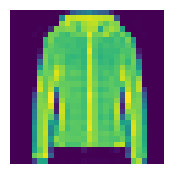

In [8]:
image = x_train[0]

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(image)
plt.show()

### Load Embedding Model

In [9]:
DEVICE = 'cuda:0'

In [10]:
class ConvMnist(nn.Module):
    def __init__(self, hidden_dim=512):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64*3*3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 10)

    def forward(self, x, return_feats=False):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)  # conv1
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # conv2
        x = F.max_pool2d(F.relu(self.conv3(x)), 2) # conv3 
        x = x.view(x.shape[0], -1) # flatten
        features = self.fc1(x)
        x = F.relu(features)
        x = self.fc2(x)
        if return_feats:
            return x, features
        else:
            return x

In [11]:
model_path = '/mnt/hdd2/liu16/convnet/unbalance_fashion_mnist_smooth0.005_size14400_v1000_b64/checkpoints/epoch_24.pt'
num_hidden = 512

record = torch.load(model_path)
model = model = ConvMnist(num_hidden)
model.load_state_dict(record['state_dict'])
model.to(DEVICE)

ConvMnist(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=576, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [12]:
root = DATA_PATH

x_train = np.expand_dims(np.load(os.path.join(root, "x_train.npy")), axis=1)
y_train = np.load(os.path.join(root, "y_train.npy"))
print(x_train.shape)

batch_size = 256
transform = transforms.Compose([
            # transforms.ToTensor(),
            transforms.Normalize(mean, std),])
train_dataset = ImageClassificationDataset(x_train, y_train, transform=transform)
dataloader = DataLoader(
    train_dataset, sampler=SequentialSampler(train_dataset), batch_size=batch_size
)

(14394, 1, 28, 28)


In [13]:
all_image_features, all_labels, all_idx = [], [], []
with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader)):
        idx, images, labels = batch
        image_features = model(images.to(DEVICE), return_feats=True)[1].squeeze()
        all_image_features.append(image_features)
        all_labels.append(labels)
        all_idx.append(idx)
        
all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
all_labels = torch.cat(all_labels).cpu().detach().numpy()
all_idx = torch.cat(all_idx).cpu().detach().numpy()

57it [00:01, 50.41it/s]


In [14]:
torch.save(all_image_features, os.path.join(DATA_PATH, f"{MODEL_NAME}_features.pt"))
torch.save(all_labels, os.path.join(DATA_PATH, f"{MODEL_NAME}_labels.pt"))
torch.save(all_idx, os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.pt"))

## Perform Quantization

In [19]:
NUM_CLUSTERS = 100
SEED = 11182023

In [20]:
all_image_features = torch.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_features.pt"))
all_labels = torch.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_labels.pt"))
all_idx = torch.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.pt"))

In [21]:
image_labels, image_cluster = cluster_feat(all_image_features, NUM_CLUSTERS, seed=SEED)

label_to_idx = np.argsort(all_idx)
print(all_idx[label_to_idx])

# have the labels correspond to the indices in order.
image_labels_sorted = image_labels[label_to_idx]
class_labels_sorted = all_labels[label_to_idx]

print(image_labels_sorted.shape)
print(class_labels_sorted.shape)

[    0     1     2 ... 14391 14392 14393]
(14394,)
(14394,)


In [22]:
save_dir = f'/mnt/ssd/ronak/datasets/{DATASET}/quantization/{MODEL_NAME}_kmeans_{NUM_CLUSTERS}'

os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, f'image_labels.npy'), image_labels_sorted)
np.save(os.path.join(save_dir, f'class_labels.npy'), class_labels_sorted)

_, counts = np.unique(all_labels, return_counts=True)
y_marginal = counts/np.sum(counts)
x_marginal = image_cluster.marginal

np.save(os.path.join(save_dir, f'image_marginal.npy'), x_marginal)
np.save(os.path.join(save_dir, f'class_marginal.npy'), y_marginal)